In [292]:
%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.60107  # in  --> Confirmed with template explanation
text_height = 9.0

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})


def errorfill(ax, x, y, yerr, color=None, alpha_fill=0.3, alpha_line=1, lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None):
    ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=alpha_line, label=label, marker=marker, markersize=markersize)

def remove_xticks(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.xaxis.set_tick_params(which='major', bottom=False, top=False)
    ax.set_xticklabels([])
        
def remove_yticks(ax):
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.yaxis.set_tick_params(which='minor', left=False)
    ax.set_yticklabels([])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [293]:
from scalable_gps.wandb_utils import load_runs_from_sweep
import numpy as np
import os

def get_sweep_id(dataset, model):
    if model == 'sgd1M':
        return {
            'pol': 'c74uixuq',
            'elevators': '4ow43hhk',
            'bike': 'ienztvmi',
            'protein': 'czbaavux'
        }[dataset]
    else:
        return {
            'pol': 'qn0yzlg8',
            'elevators': '3tq6po58',
            'bike': 'f1fosp12',
            'protein': 'xjxvobap'
        }[dataset]

# datasets = ['protein']
datasets = ['pol', 'elevators', 'bike', 'protein']
models = ['cg', 'precondcg', 'sgd']

config_keys = ['dataset_config.split', 'model_name', 'override_noise_scale']
metric_keys = ['wall_clock_time', 'train/alpha_diff', 'train/alpha_rkhs_diff', 'train/y_pred_diff', 'train/normalised_test_rmse']

n_splits = 10

results_path = "./exact_metrics_results.npy"

if os.path.isfile(results_path):
    results = np.load(results_path, allow_pickle=True).item()
else:
    results = dict()

for dataset in datasets:
    if dataset in results.keys():
        print(f"Results for '{dataset}' already exist.")
        continue
    results[dataset] = dict()
    
    for model in models:
        results[dataset][model] = dict()
        n_evals = 1000

        for metric in metric_keys:
            results[dataset][model][metric] = np.zeros((2, n_splits, n_evals)) # dim 0 = override noise

    print(f"Downloading results for {dataset}, {model}")
    configs_and_metrics = load_runs_from_sweep(get_sweep_id(dataset, model), config_keys, metric_keys)

    for (configs, metrics) in configs_and_metrics:
        split = configs['dataset_config.split']
        model = configs['model_name']
        override_noise_idx = 0 if configs['override_noise_scale'] == -1 else 1

        for metric in metric_keys:
            results[dataset][model][metric][override_noise_idx, split] = metrics[metric]
    
    # load 1M sgd
    model = 'sgd1M'
    results[dataset][model] = dict()
    n_evals = 10000
    for metric in metric_keys:
        results[dataset][model][metric] = np.zeros((2, n_splits, n_evals)) # dim 0 = override noise
    print(f"Downloading results for {dataset}, {model}")
    configs_and_metrics = load_runs_from_sweep(get_sweep_id(dataset, model), config_keys, metric_keys)
    for (configs, metrics) in configs_and_metrics:
        split = configs['dataset_config.split']
        override_noise_idx = 0 if configs['override_noise_scale'] == -1 else 1

        for metric in metric_keys:
            results[dataset][model][metric][override_noise_idx, split] = metrics[metric]

np.save(results_path, results)


Results for 'pol' already exist.
Results for 'elevators' already exist.
Results for 'bike' already exist.
Results for 'protein' already exist.


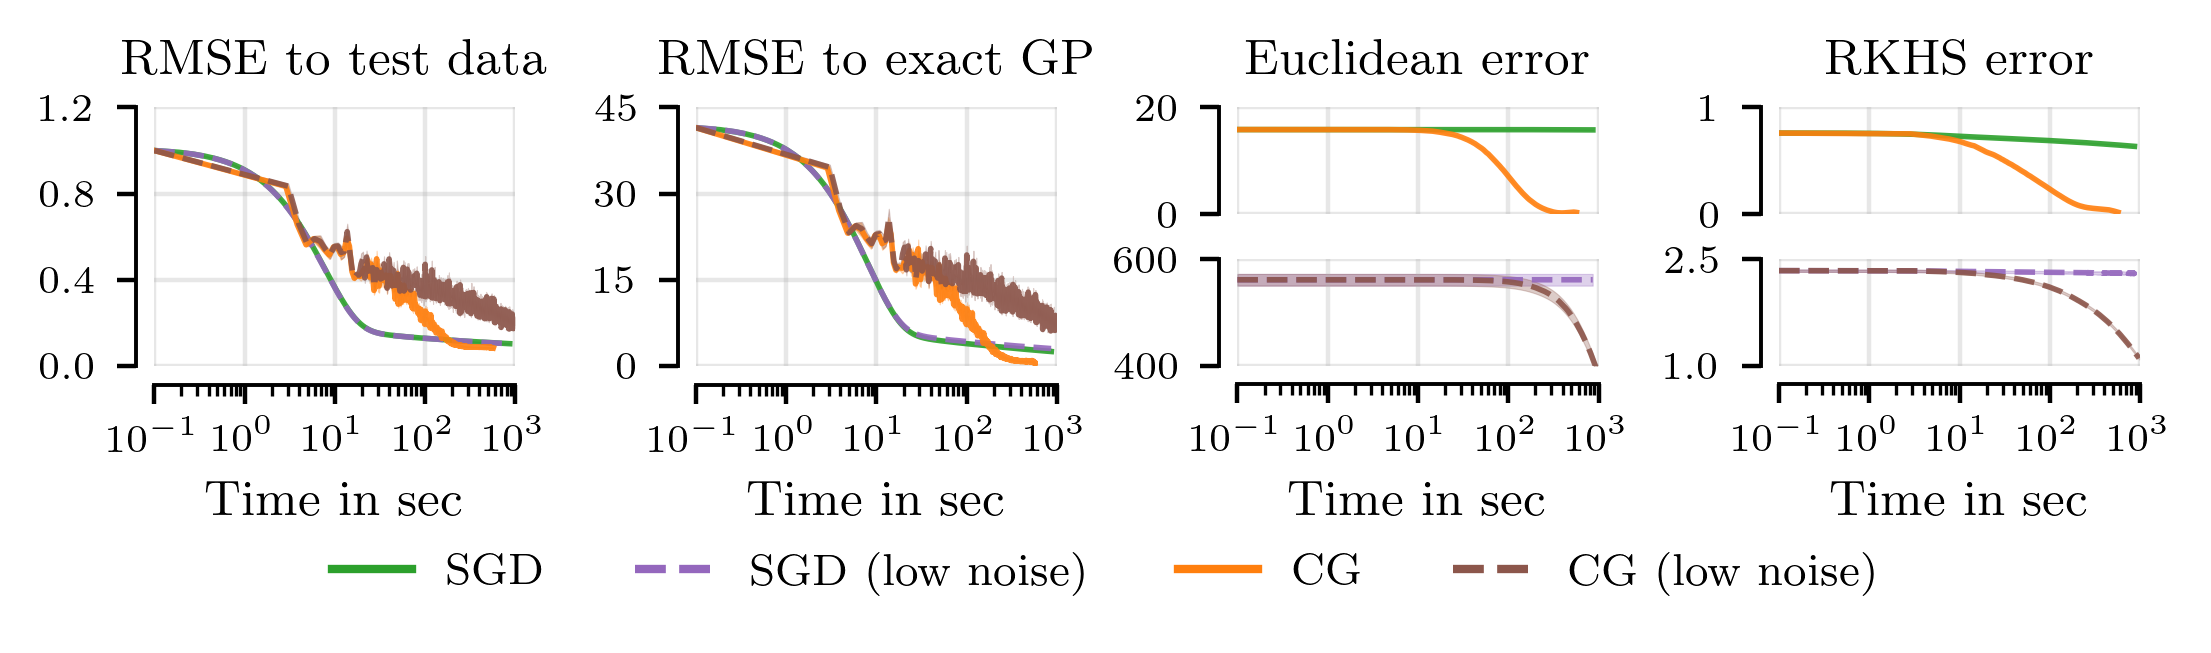

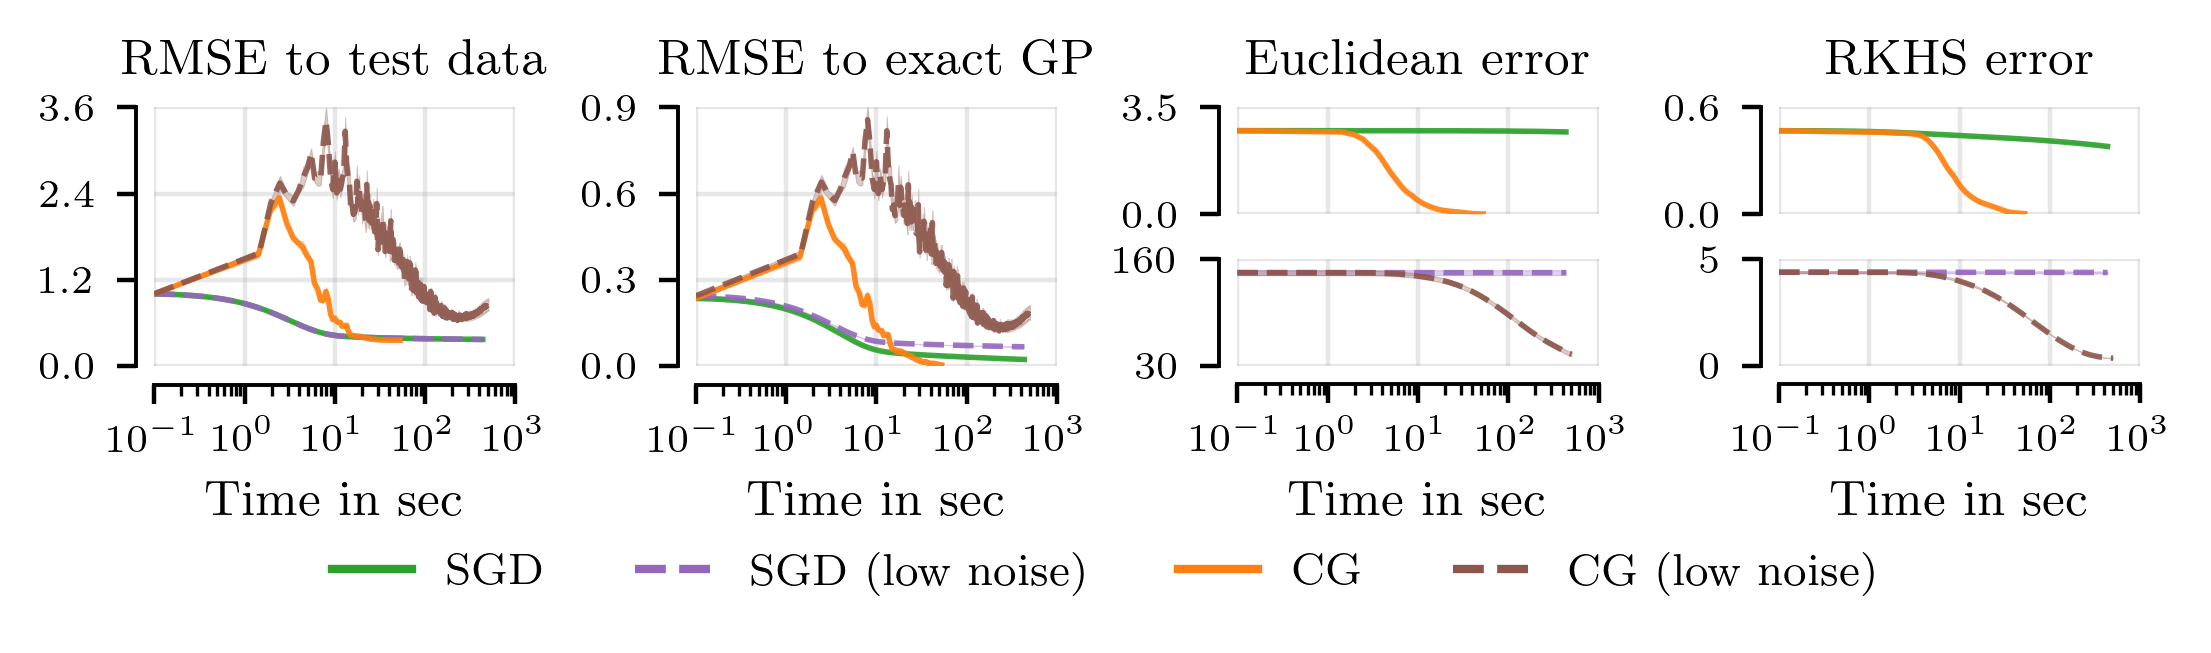

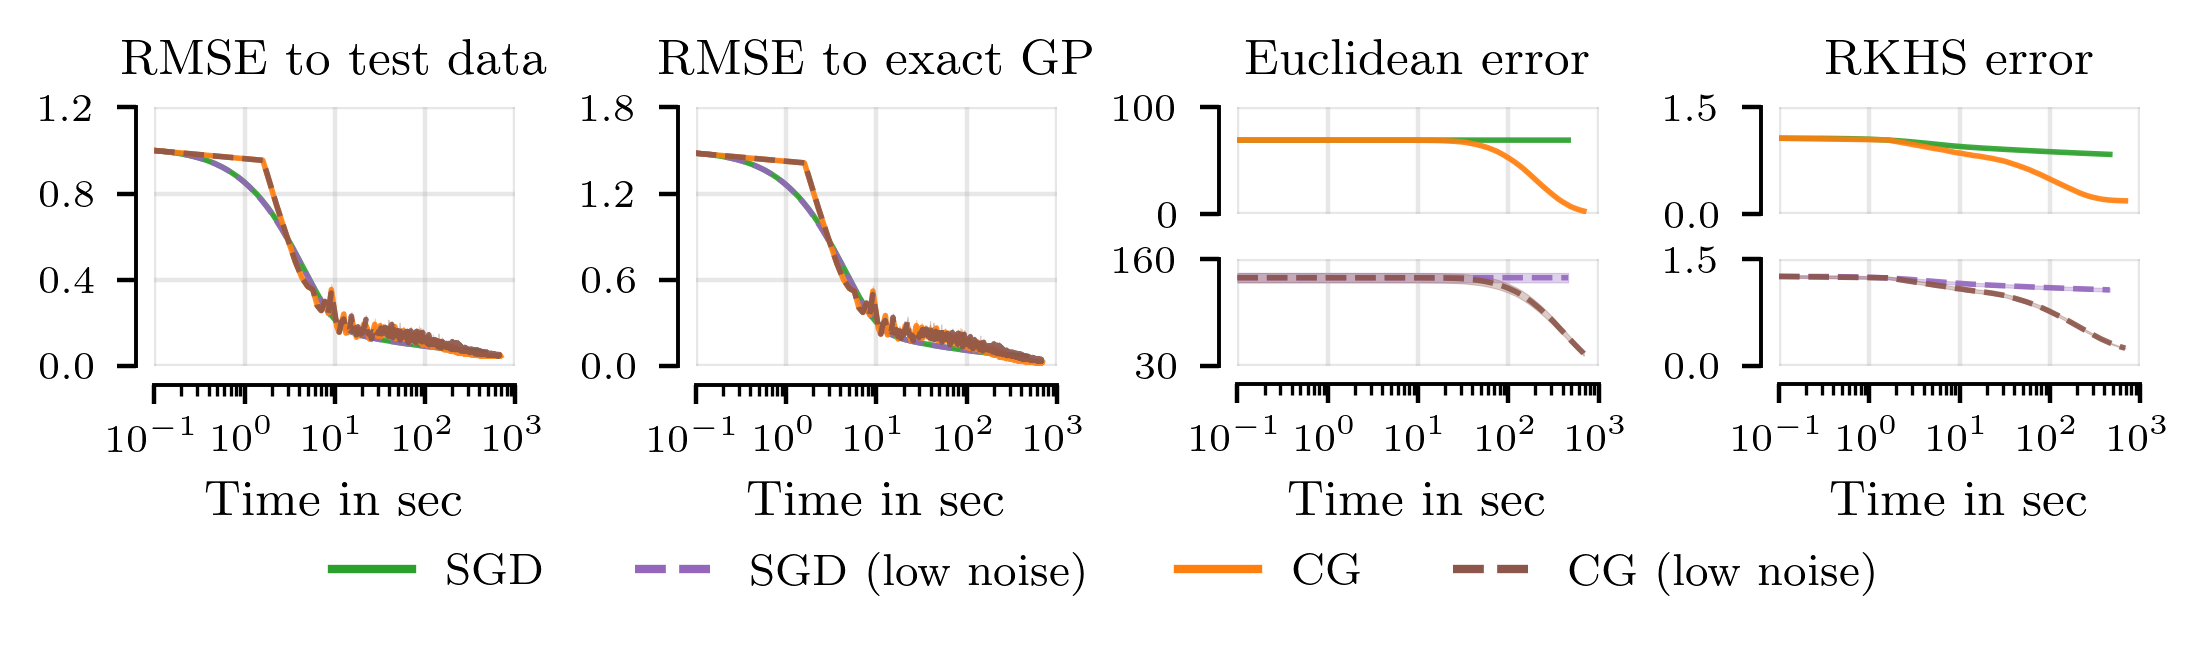

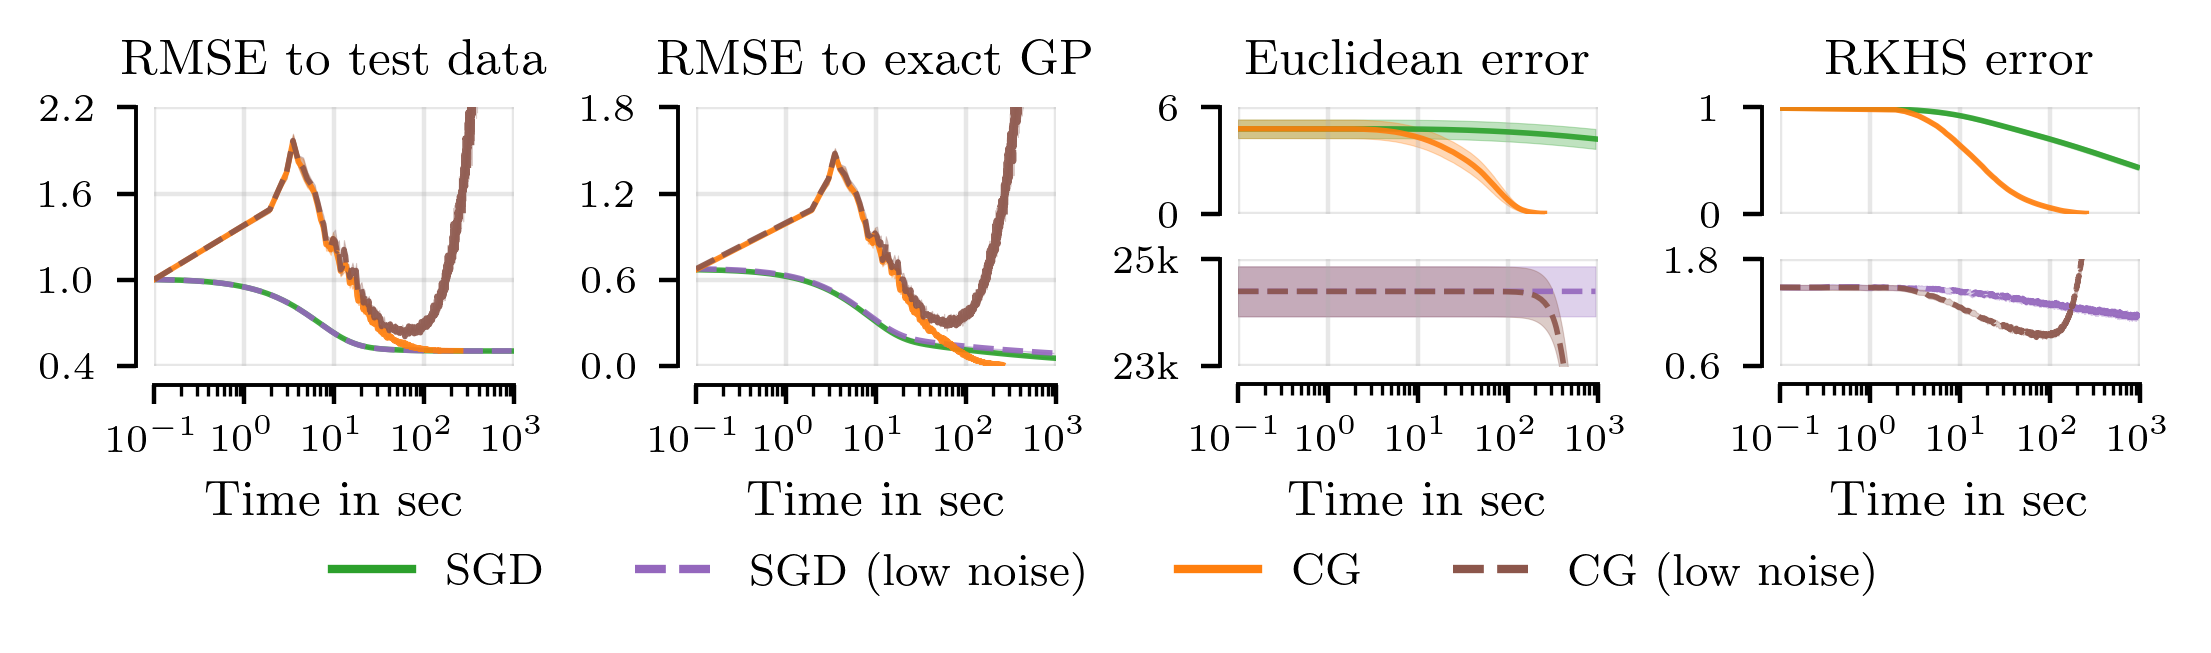

In [302]:
def get_color(model, override_noise):
    if 'cg' in model:
        if override_noise:
            return 'tab:brown'
        else:
            return 'tab:orange'
    elif 'sgd' in model:
        if override_noise:
            return 'tab:purple'
        else:
            return 'tab:green'
    else:
        return 'magenta'

def get_linestyle(override_noise):
    return '--' if override_noise else '-'

def get_label(model, override_noise):
    if 'cg' in model:
        if override_noise:
            return "CG (low noise)"
        else:
            return "CG"
    elif 'sgd' in model:
        if override_noise:
            return "SGD (low noise)"
        else:
            return "SGD"
    else:
        return 'null'
    
def get_yticks(dataset):
    if dataset == 'protein':
        return [(0.4, 1.0, 1.6, 2.2),
                (0, 0.6, 1.2, 1.8),
                (0, 6),
                (23000, 25000),
                (0, 1),
                (0.6, 1.8)]
    elif dataset == 'pol':
        return [(0.0, 0.4, 0.8, 1.2),
                (0, 15, 30, 45),
                (0, 20),
                (400, 600),
                (0, 1),
                (1.0, 2.5)]
    elif dataset == 'elevators':
        return [(0, 1.2, 2.4, 3.6),
                (0, 0.3, 0.6, 0.9),
                (0, 3.5),
                (30, 160),
                (0, 0.6),
                (0, 5)]
    elif dataset == 'bike':
        return [(0, 0.4, 0.8, 1.2),
                (0, 0.6, 1.2, 1.8),
                (0, 100),
                (30, 160),
                (0, 1.5),
                (0, 1.5)]

def get_yticklabels(dataset):
    if dataset == 'protein':
        return [None,
                None,
                None,
                ("23k", "25k"),
                None,
                None]
    else:
        return 6 * [None]

alpha_line = 0.9

max_time = 1000
xlim = (0.1, max_time)
titles = ["RMSE to test data",
          "RMSE to exact GP",
          #r"$\| \mathbf{K}_{\tilde{\boldsymbol{x}}\boldsymbol{x}}\boldsymbol{v} - \mathbf{K}_{\tilde{\boldsymbol{x}}\boldsymbol{x}}\boldsymbol{v}^* \|_2$",
          #r"$\| \boldsymbol{v} - \boldsymbol{v}^* \|_2$",
          "Euclidean error",
          None,
          #r"$\| \boldsymbol{v} - \boldsymbol{v}^* \|_{\mathbf{K}_{\boldsymbol{x}\boldsymbol{x}}}$",
          "RKHS error",
          None]
metrics = ['train/normalised_test_rmse', 'train/y_pred_diff',
            'train/alpha_diff', 'train/alpha_diff',
            'train/alpha_rkhs_diff', 'train/alpha_rkhs_diff']
models = ['sgd1M', 'precondcg']

legend_handles = []
for model in models:
    for override_noise_idx in [0, 1]:
        c = get_color(model, override_noise_idx)
        label = get_label(model, override_noise_idx)
        ls = get_linestyle(override_noise_idx)
        legend_handles.append(Line2D([], [], color=c, label=label, linestyle=ls))

for dataset in datasets:
# for dataset in ['protein']:
    fig = plt.figure(dpi=400, figsize=[text_width, 0.17 * text_height])
    gs = GridSpec(2, 4, figure=fig)
    xlim = (0.1, max_time)
    yticks = get_yticks(dataset)
    yticklabels = get_yticklabels(dataset)

    ax_test_rmse = fig.add_subplot(gs[:, 0])
    ax_y_pred_diff = fig.add_subplot(gs[:, 1])
    ax_alpha_diff_regular_noise = fig.add_subplot(gs[0, 2])
    ax_alpha_diff_low_noise = fig.add_subplot(gs[1, 2])
    ax_alpha_diff_rkhs_regular_noise = fig.add_subplot(gs[0, 3])
    ax_alpha_diff_rkhs_low_noise = fig.add_subplot(gs[1, 3])

    axes = [ax_test_rmse, ax_y_pred_diff,
            ax_alpha_diff_regular_noise, ax_alpha_diff_low_noise,
            ax_alpha_diff_rkhs_regular_noise, ax_alpha_diff_rkhs_low_noise]

    for i, ax in enumerate(axes):
        ax.grid(alpha=0.3)
        ax.semilogx()
        ax.set_xlim(*xlim)
        ax.set_xlabel("Time in sec")
        ax.set_yticks(yticks[i])
        ax.set_ylim(np.min(yticks[i]), np.max(yticks[i]))
        if yticklabels[i]:
            ax.set_yticklabels(yticklabels[i])
        ax.set_title(titles[i])

        ax.spines[['top', 'right']].set_visible(False)
        ax.spines['bottom'].set_position(('axes', -0.075))
        ax.spines['left'].set_position(('axes', -0.05))

    remove_xticks(ax_alpha_diff_regular_noise)
    ax_alpha_diff_regular_noise.spines['bottom'].set_visible(False)
    ax_alpha_diff_regular_noise.set_xlabel(None)
    ax_alpha_diff_low_noise.spines['bottom'].set_position(('axes', -0.175))
    remove_xticks(ax_alpha_diff_rkhs_regular_noise)
    ax_alpha_diff_rkhs_regular_noise.spines['bottom'].set_visible(False)
    ax_alpha_diff_rkhs_regular_noise.set_xlabel(None)
    ax_alpha_diff_rkhs_low_noise.spines['bottom'].set_position(('axes', -0.175))

    for model in models:
        for override_noise_idx in [0, 1]:
            c = get_color(model, override_noise_idx)
            ls = get_linestyle(override_noise_idx)

            time = np.mean(results[dataset][model]['wall_clock_time'][override_noise_idx], axis=0)
            time = time - time[0] + xlim[0]

            for (metric, ax) in zip(metrics, axes):
                if (ax == ax_alpha_diff_regular_noise or ax == ax_alpha_diff_rkhs_regular_noise) and override_noise_idx:
                    continue
                if (ax == ax_alpha_diff_low_noise or ax == ax_alpha_diff_rkhs_low_noise) and not override_noise_idx:
                    continue
                mean = np.mean(results[dataset][model][metric][override_noise_idx], axis=0)
                err = np.std(results[dataset][model][metric][override_noise_idx], axis=0) / np.sqrt(n_splits)

                errorfill(ax, time, mean, err, color=c, alpha_line=alpha_line, linestyle=ls)

    fig.legend(handles=legend_handles, ncols=4, loc='center', bbox_to_anchor=(0.5, 0.04), handlelength=1.8, fontsize=8, frameon=False)

    fig.tight_layout(w_pad=0.5, h_pad=0.2)
    fig.savefig(f"../../figures/exact_metrics_{dataset}.pdf", bbox_inches='tight', pad_inches=0.01)
    fig.savefig(f"../../figures/exact_metrics_{dataset}.png", bbox_inches='tight', pad_inches=0.01)

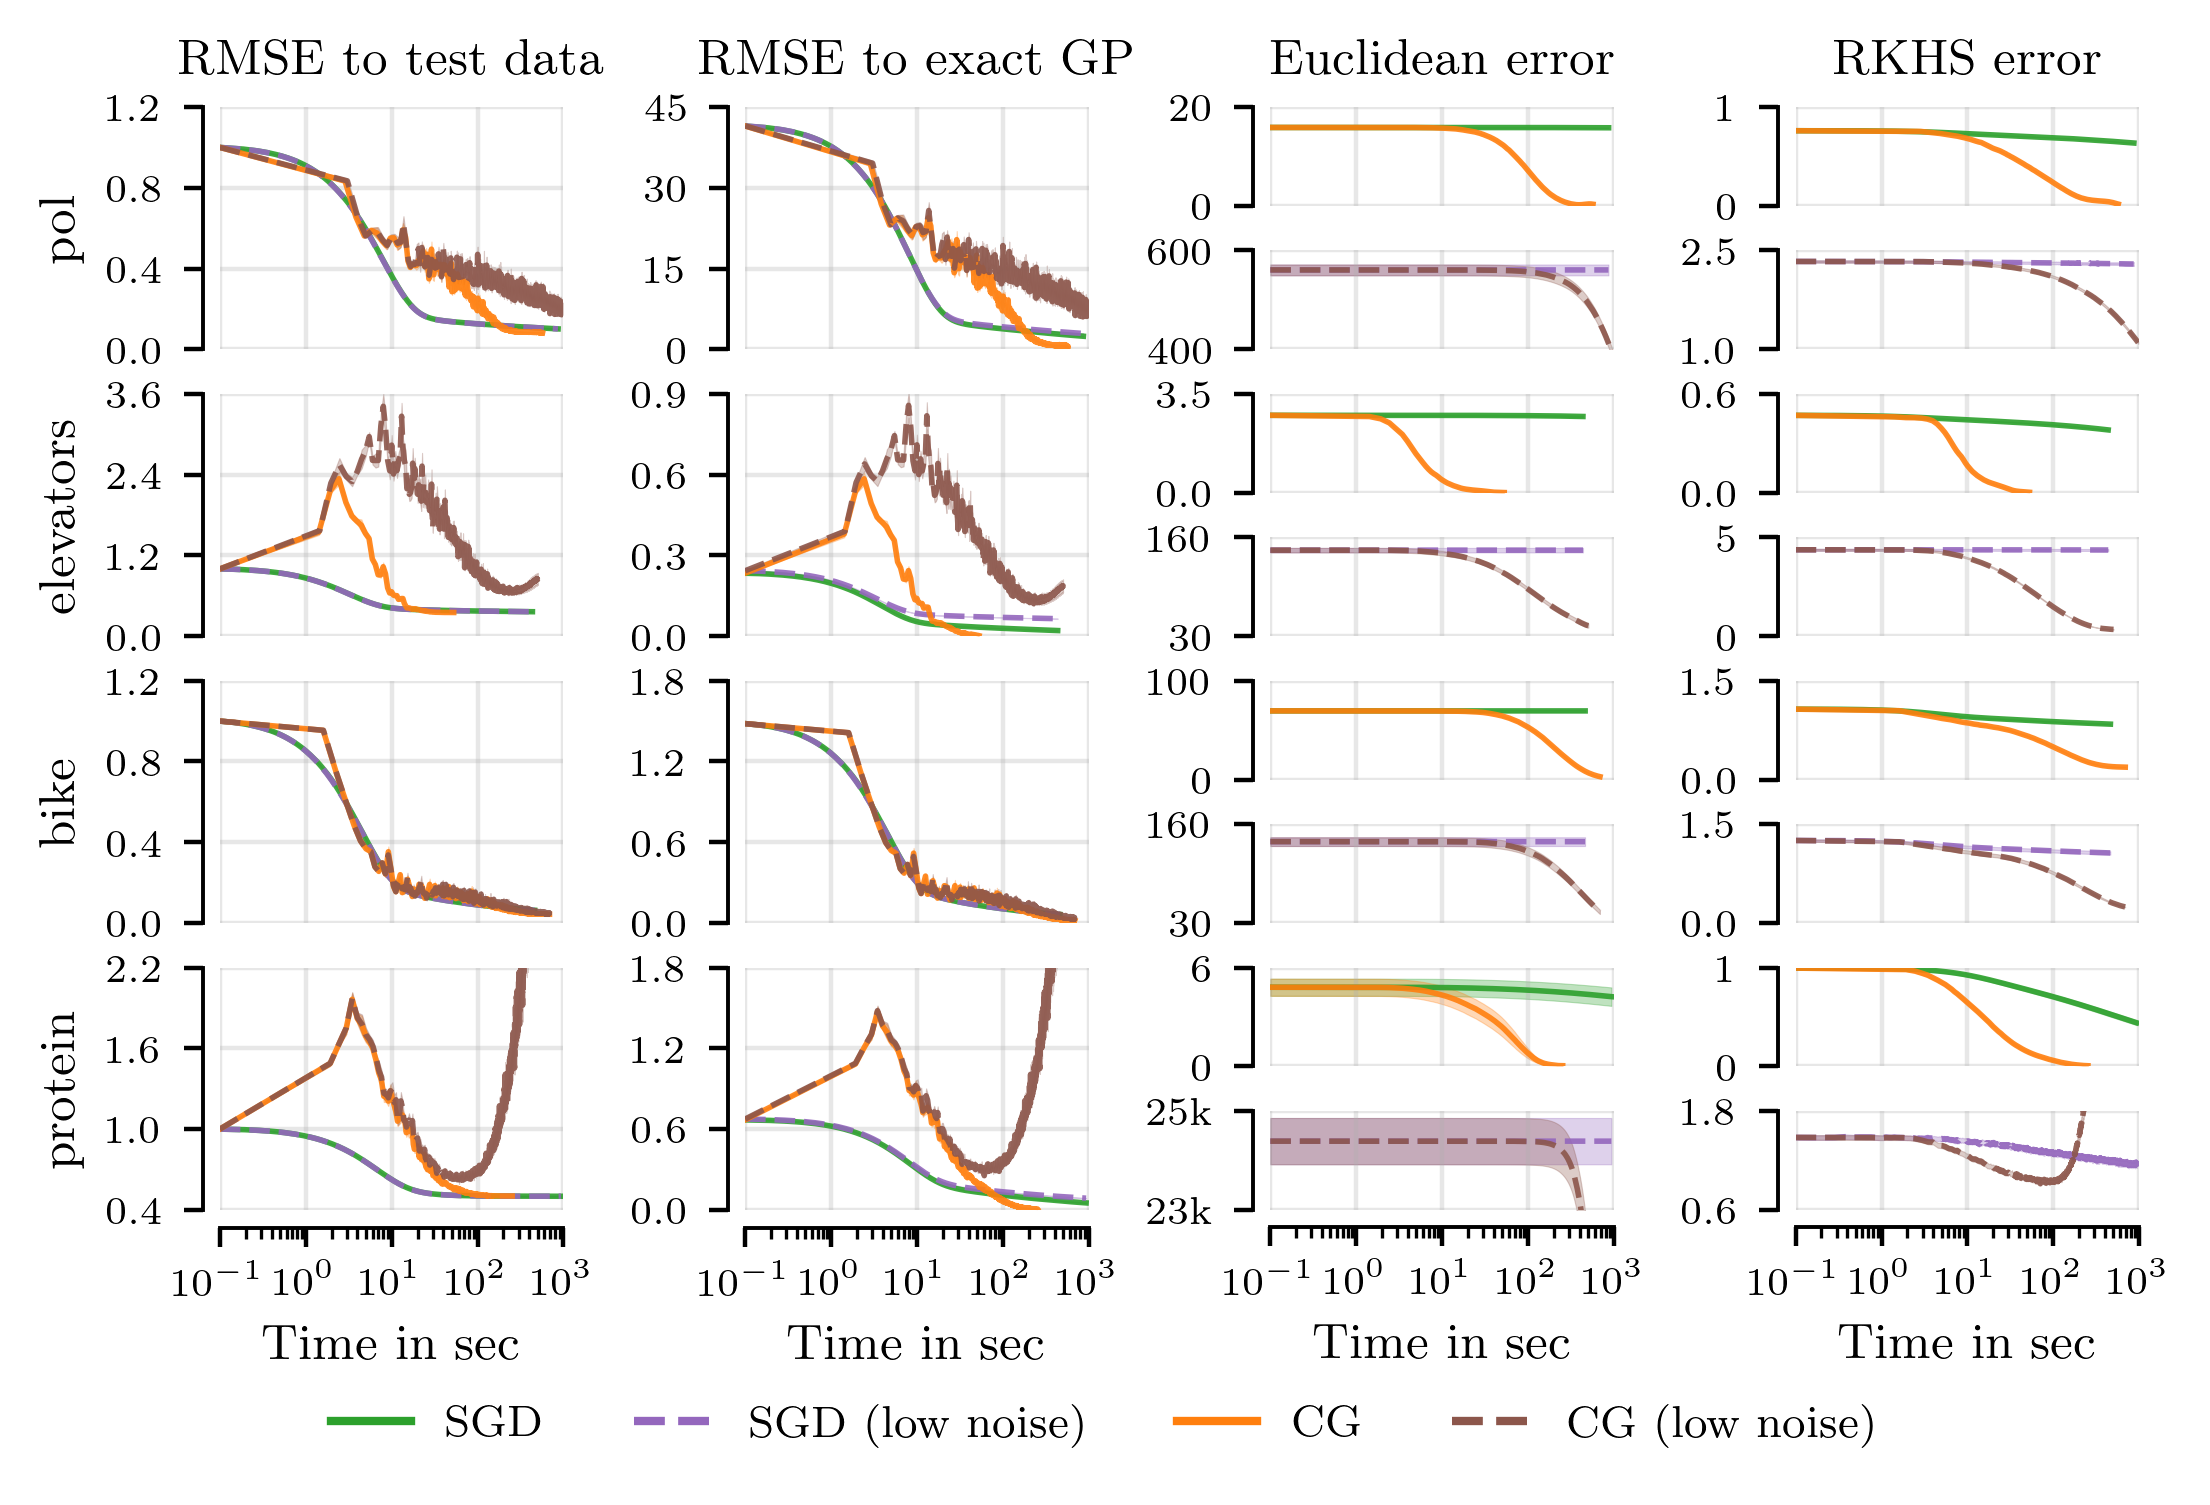

In [301]:
# appendix figure with all datasets

fig = plt.figure(dpi=400, figsize=[text_width, 0.4 * text_height])
gs = GridSpec(2 * len(datasets), 4, figure=fig)

for j, dataset in enumerate(datasets):
    yticks = get_yticks(dataset)
    yticklabels = get_yticklabels(dataset)

    idx = 2 * j
    ax_test_rmse = fig.add_subplot(gs[idx:idx+2, 0])
    ax_y_pred_diff = fig.add_subplot(gs[idx:idx+2, 1])
    ax_alpha_diff_regular_noise = fig.add_subplot(gs[idx, 2])
    ax_alpha_diff_low_noise = fig.add_subplot(gs[idx+1, 2])
    ax_alpha_diff_rkhs_regular_noise = fig.add_subplot(gs[idx, 3])
    ax_alpha_diff_rkhs_low_noise = fig.add_subplot(gs[idx+1, 3])

    ax_test_rmse.set_ylabel(dataset)

    axes = [ax_test_rmse, ax_y_pred_diff,
            ax_alpha_diff_regular_noise, ax_alpha_diff_low_noise,
            ax_alpha_diff_rkhs_regular_noise, ax_alpha_diff_rkhs_low_noise]
    
    for i, ax in enumerate(axes):
        ax.grid(alpha=0.3)
        ax.semilogx()
        ax.set_xlim(*xlim)
        ax.set_xlabel("Time in sec")
        ax.set_yticks(yticks[i])
        ax.set_ylim(np.min(yticks[i]), np.max(yticks[i]))
        if yticklabels[i]:
            ax.set_yticklabels(yticklabels[i])
        ax.set_title(titles[i])

        ax.spines[['top', 'right']].set_visible(False)
        ax.spines['bottom'].set_position(('axes', -0.075))
        ax.spines['left'].set_position(('axes', -0.05))

        if j != 0:
            ax.set_title(None)

        if j != len(datasets) - 1:
            ax.spines['bottom'].set_visible(False)
            remove_xticks(ax)
            ax.set_xlabel(None)

    remove_xticks(ax_alpha_diff_regular_noise)
    ax_alpha_diff_regular_noise.spines['bottom'].set_visible(False)
    ax_alpha_diff_regular_noise.set_xlabel(None)
    ax_alpha_diff_low_noise.spines['bottom'].set_position(('axes', -0.175))
    remove_xticks(ax_alpha_diff_rkhs_regular_noise)
    ax_alpha_diff_rkhs_regular_noise.spines['bottom'].set_visible(False)
    ax_alpha_diff_rkhs_regular_noise.set_xlabel(None)
    ax_alpha_diff_rkhs_low_noise.spines['bottom'].set_position(('axes', -0.175))

    for model in models:
        for override_noise_idx in [0, 1]:
            c = get_color(model, override_noise_idx)
            ls = get_linestyle(override_noise_idx)

            time = np.mean(results[dataset][model]['wall_clock_time'][override_noise_idx], axis=0)
            time = time - time[0] + xlim[0]

            for (metric, ax) in zip(metrics, axes):
                if (ax == ax_alpha_diff_regular_noise or ax == ax_alpha_diff_rkhs_regular_noise) and override_noise_idx:
                    continue
                if (ax == ax_alpha_diff_low_noise or ax == ax_alpha_diff_rkhs_low_noise) and not override_noise_idx:
                    continue
                mean = np.mean(results[dataset][model][metric][override_noise_idx], axis=0)
                err = np.std(results[dataset][model][metric][override_noise_idx], axis=0) / np.sqrt(n_splits)

                errorfill(ax, time, mean, err, color=c, alpha_line=alpha_line, linestyle=ls)

fig.legend(handles=legend_handles, ncols=4, loc='center', bbox_to_anchor=(0.5, 0.0), handlelength=1.8, fontsize=8, frameon=False)
fig.tight_layout(w_pad=0.5, h_pad=0.2)
fig.savefig("../../figures/exact_metrics_all.pdf", bbox_inches='tight', pad_inches=0.01)
fig.savefig("../../figures/exact_metrics_all.png", bbox_inches='tight', pad_inches=0.01)